In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw2.ipynb")

## Homework #2

*Please edit the cell below to add your full name (first and last) and the full names of any group members that you collaborated with on this assignment.* 

Name: Iris Liu  
Group Members:   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

<!-- BEGIN QUESTION -->

**Important Note**: *All solutions to the problems below must use the approaches taught so far in the course for answering the questions. There are other approaches for solving these problems that do not require the use of Bayesian approaches, PyMC, quadratic approximation, etc. However, we will soon encounter problems where those tools lack the functionality that is needed to solve the problems. It will be to your benefit to practice using the approach shown in lecture and found in the textbook to begin practicing for what is to come later. In addition, you will not receive full credit on your answers if you do not use the techniques being taught in the course. When performing quadratic approximations in this assignment, do not implement a new version of the technique; simply **use the `quap` function to receive credit for your solution**.*

**Question 1 (20 points)**. Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 (`Data/Howell1.csv`) dataset. **Be sure to use a quadratic approximation of the posterior distribution as demonstrated in lecture.**

**Note** : _Complete this exercise without using the `pymc.sample_posterior_predictive` function._

In [3]:
import pandas as pd
import pymc as pm
import arviz as az
from quap import quap
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Write code here
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]
H = d2.height
W = d2.weight

with pm.Model() as m_adults:
    a = pm.Normal("a", mu=60, sigma=10)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    mu = pm.Deterministic("mu", a + b * (H - H.mean()))
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=W)
    
    idata, posterior = quap([a, b, sigma], n_samples=10000)


In [5]:
az.summary(idata, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,44.999,0.226,44.634,45.355
b,0.629,0.046,0.559,0.705
sigma,4.230,0.065,4.127,4.332


Consider the heights listed below which were recorded in the community census, but weights were not recorded for these individuals. Provide predicted weights and 89% HPD intervals for each of these individuals. That is, fill in the table below, using model-based predictions **of outcome weights. This requires simulating weights from the model's data distribution/likelihood using samples from the posterior distribution. Report the average weight prediction for each height in the table.** 

The table can be edited by double-clicking in the cell containing the table, copying the Markdown within the cell, and pasting the contents to another **Markdown cell** which can then be edited.

In [13]:
# Write code here

# Draw from posterior
post = az.extract(idata)
a_samp = post.a.values
b_samp = post.b.values
sigma_samp = post.sigma.values

# Predict weights
heights = np.array([140, 160, 175])
pred_means, pred_intervals = [], []

for h in heights:
    mu_pred = a_samp + b_samp * (h - H.mean()) # Expected weights
    w_pred = stats.norm.rvs(loc=mu_pred, scale=sigma_samp)
    pred_means.append(w_pred.mean()) # Average weight prediction
    pred_intervals.append(az.hdi(w_pred, hdi_prob=0.89)) # HDI

# Print results
for i, h in enumerate(heights, 1):
    print(f"Individual {i}: height={h}, "
          f"predicted weight={pred_means[i-1]:.2f}, "
          f"89% interval={pred_intervals[i-1]}")
    

Individual 1: height=140, predicted weight=35.86, 89% interval=[28.98080709 42.56442029]
Individual 2: height=160, predicted weight=48.42, 89% interval=[41.80639652 55.31744591]
Individual 3: height=175, predicted weight=57.77, 89% interval=[50.77713546 64.57245188]


|Individual|height|predicted weight|89% interval|
|:---|:---|:---|:---|
| 1 | 140 | 35.86 | (28.98080709, 42.56442029) |
| 2 | 160 | 48.42 | (41.80639652, 55.31744591)|
| 3 | 175 | 57.77 | (50.77713546, 64.57245188)| 

|Individual|height|predicted weight|89% interval|
|:---|:---|:---|:---|
| 1 | 140 |  | ( , ) |
| 2 | 160 |  | ( , )|
| 3 | 175 |  | ( , )| 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2 (20 points)**. From the Howell1 dataset, consider only the **people younger than 13 years old**.

In this problem, you will estimate the causal association between age and weight using linear regression. Assume that age influences weight through two paths.
- First, age influences height, and height influences weight.
- Second, age directly influences weight through age-related changes in muscle growth and body proportions.

All of this implies the following causal model (represented as a DAG):

![HW2 DAG](dag.png)

Your model intercept will be interpreted as the **expected weight at birth** and the causal effect will estimate how **each year of growth** influences weight.

**Be sure to carefully consider** and **justify the priors** used. *Hint: remember that the intercept represents the expected weight at birth*. Justification for the prior distributions used **must include a prior predictive simulation** to assess the implications of your prior choice. 

**Note** : _For this excercise, perform the prior predictive simulation manually (i.e. do not use `pymc.sample_prior_predictive`)._

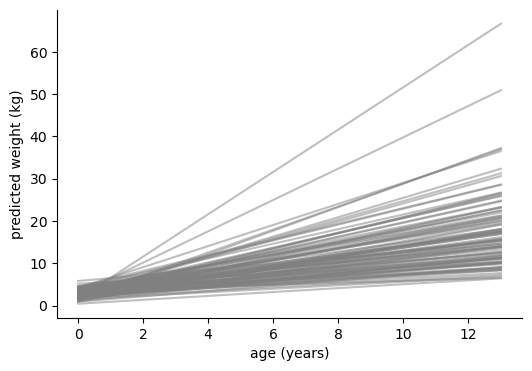

In [22]:
# Write code here

N = 100

# a ~ Normal(3,1)
a_prior = stats.norm.rvs(3,1, size=N)

# b ~ LogNormal(0,0.5)
b_prior = stats.lognorm.rvs(s=0.5, loc = 0, size=N)  

age_seq = np.array([0, 13])

plt.figure(figsize=(6, 4))

for i in range(N):
    w = a_prior[i] + b_prior[i] * age_seq
    plt.plot(age_seq, w, color = "gray", alpha = 0.5)

plt.xlabel("age (years)")
plt.ylabel("predicted weight (kg)")
sns.despine()

In [24]:
# Prior predictive simulation

n_kids = 100
A = stats.uniform.rvs(0, 13, n_kids)

# True model parameters
a_sim = 4
b_sim = 2
sigma_sim = 0.5

# Simulate observed weights
mu_sim = a_sim + b_sim * A
W_sim = stats.norm.rvs(mu_sim, sigma_sim, n_kids)

# Fit model using previously set priors
with pm.Model() as m_prior_test:
    a = pm.Normal("a", mu=3, sigma=1) # alpha ~ Normal(3,1)
    b = pm.Lognormal("b", mu=0, sigma=0.5) # beta ~ LogNormal(0,0.5)
    sigma = pm.Uniform("sigma", lower=0, upper=10) # sigma ~ Uniform(0,10)
    
    mu = pm.Deterministic("mu", a + b * A)
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=W_sim)
    
    idata, _ = quap([a, b, sigma], n_samples=10000)

# Step 5: summarize the posterior
az.summary(idata, kind="stats", hdi_prob=0.89)


,mean,sd,hdi_5.5%,hdi_94.5%
a,4.068,0.101,3.903,4.227
b,1.991,0.007,1.981,2.002
sigma,0.521,0.074,0.401,0.639


JUSTIFICATION: The chosen priors capture the true values of the simulated alpha, beta, and sigma, as these true values fall within the 89% HDI of the predicted results. The prior for alpha is specified as a normal distribution, Normal(3, 1). An expected birth weight of 3 kg is used because the average birth weight of newborns in Africa is approximately 3 kg. The prior for beta is specified as a log-normal distribution, LogNormal(0, 0.5), to make sure that it remains positive. The prior for sigma is specified as a uniform distribution over the interval [0, 10], same as the one used in class.

Next, **using a quadratic approximation of the posterior distribution**, estimate the **total (not just direct)** causal effect of **each year of growth** on weight.   
*Be sure to provide your answer in a form that represents the uncertainty of the estimate for this causal effect. A distribution plot is most effective for this purpose.*

In [25]:
# Write code here

d_kid = d[d.age < 13]
A = d_kid.age.values
W = d_kid.weight.values

with pm.Model() as m_kids:
    a = pm.Normal("a", mu=3, sigma=1)        
    b = pm.Lognormal("b", mu=0, sigma=0.5)      
    sigma = pm.Uniform("sigma", lower=0, upper=10)

    mu = pm.Deterministic("mu", a + b * A)
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=W)

    idata, _ = quap([a, b, sigma], n_samples=10000)

# summarize posterior
az.summary(idata, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,6.951,0.351,6.416,7.533
b,1.401,0.038,1.339,1.460
sigma,2.541,0.080,2.417,2.672


/opt/conda/envs/fnds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


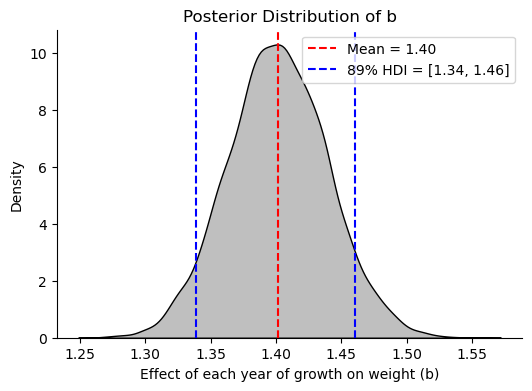

In [34]:
# Extract posterior samples of b
post = az.extract(idata)
b_samples = post.b.values

# Mean and HDI of b
b_mean = b_samples.mean()
b_hdi = az.hdi(b_samples, hdi_prob=0.89)

# Plot the distribution of B
plt.figure(figsize=(6, 4))
sns.kdeplot(b_samples, fill=True, color="black")
plt.axvline(b_mean, color="red", linestyle="--", label=f"Mean = {b_mean:.2f}")
plt.axvline(b_hdi[0], color="blue", linestyle="--", label=f"89% HDI = [{b_hdi[0]:.2f}, {b_hdi[1]:.2f}]")
plt.axvline(b_hdi[1], color="blue", linestyle="--")
plt.xlabel("Effect of each year of growth on weight (b)")
plt.title("Posterior Distribution of b")
plt.legend()
sns.despine()
plt.show()

In [35]:
# # Plot original data
# plt.figure(figsize=(8, 5))
# _ = plt.scatter(A, W, facecolors='none', edgecolors="#e06666", label="Observed data")
# _ = plt.xlabel("age (years)")
# _ = plt.ylabel("weight (kg)")
# _ = sns.despine()

# age_seq = np.linspace(0, 13, 100)  

# post = az.extract(idata)
# a_samp = post.a.values
# b_samp = post.b.values
# mu_pred = np.zeros((len(age_seq), len(a_samp)))

# for i, a in enumerate(age_seq):
#     mu_pred[i] = a_samp + b_samp * a

# mu_mean = mu_pred.mean(1)

# # -------- Step 4: Plot prediction line (mean of μ) --------
# _ = plt.plot(age_seq, mu_mean, color='black', label="Mean prediction (μ)")

# # -------- Step 5: Plot HDI for μ --------
# ax = az.plot_hdi(age_seq, mu_pred.T, color='yellow', hdi_prob=0.89)

# # -------- Step 6: Compute posterior predictive distribution --------
# sigma_values = idata_thinned.sigma.values
# mu_pred_obs = np.zeros((len(A), len(a_values)))
# weight_pred = np.zeros_like(mu_pred_obs)

# for i, a in enumerate(A):
#     mu_pred_obs[i] = a_values + b_values * a
#     weight_pred[i] = stats.norm.rvs(loc=mu_pred_obs[i], scale=sigma_values)

# # -------- Step 7: Plot HDI for predicted weights --------
# _ = az.plot_hdi(A, weight_pred.T, ax=ax, color="gray", hdi_prob=0.89)

# # -------- Final plot tweaks --------
# plt.xlim(-0.5, 13.5)
# plt.legend()
# plt.title("Children: Observed Data, Model Prediction, and Uncertainty")
# plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3 (10 points)**. Now suppose the causal association between age and weight might be different based on reported gender for the same age group as in Question 2. 

Use a single linear regression, with a categorical variable for gender, to **estimate the total causal effect** of age on weight separately for boys and girls.

Be sure to **use index-based encoding of the categories** and **approximate the posterior distribution using a quadratic approximation** as demonstrated in lecture.

In [36]:
# Write code here
G = d_kid.male.values

with pm.Model() as m_age_gender:
    a = pm.Normal("a", mu=3, sigma=1, shape=2)           
    b = pm.Lognormal("b", mu=0, sigma=0.5, shape=2)       
    sigma = pm.Uniform("sigma", lower=0, upper=10)

    mu = pm.Deterministic("mu", a[G] + b[G] * A)
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=W)

    idata, _ = quap([a, b, sigma], n_samples=10000)

az.summary(idata, kind="stats", hdi_prob=0.89)


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],6.312,0.447,5.566,6.994
a[1],6.897,0.468,6.194,7.685
b[0],1.379,0.051,1.300,1.460
b[1],1.507,0.048,1.434,1.588
sigma,2.474,0.080,2.345,2.601


/opt/conda/envs/fnds/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/l

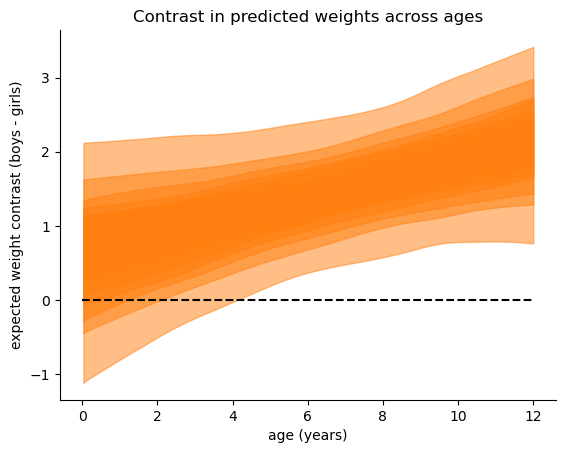

In [37]:
# Contrast plot

age_seq = np.arange(0, 13)

post = az.extract(idata)

mu_pred_girls = np.empty((len(age_seq), post.sizes["sample"]))
mu_pred_boys = np.empty((len(age_seq), post.sizes["sample"]))

for i, age in enumerate(age_seq):
    mu_pred_girls[i] = post.a.values[0] + post.b.values[0] * age
    mu_pred_boys[i] = post.a.values[1] + post.b.values[1] * age

mu_contrast = mu_pred_boys - mu_pred_girls 

for p in [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    az.plot_hdi(age_seq, mu_contrast.T, hdi_prob=p)

plt.plot(age_seq, [0]*len(age_seq), "k--")  # baseline
plt.xlabel("age (years)")
plt.ylabel("expected weight contrast (boys - girls)")
plt.title("Contrast in predicted weights across ages")
sns.despine()


How do girls and boys differ according to your model results? **Limit your response to no more than 3 sentences.**
- Provide one or more posterior contrast plots to support your answer.

The model suggests that boys tend to be heavier than girls from an early age, and that this difference increases steadily as they grow older. By age 5, the predicted weight contrast is positive across all HDI intervals. The model also indicates greater individual variation in the weights of boys and girls during infancy and later childhood, as shown by the wider HDI intervals at those stages.

In [24]:
# def filled_contrast_dist(w_contrast):
#     kde = stats.gaussian_kde(w_contrast)
#     # plot complete kde curve as line
#     pos = np.linspace(w_contrast.min(), w_contrast.max(), 101)
#     plt.plot(pos, kde(pos), color="w")
#     # plot shaded kde only right of x=0
#     shade_M = np.linspace(0, w_contrast.max(), 101)
#     plt.fill_between(shade_M, kde(shade_M), alpha=0.5, color="#e06666")

#     # plot shaded kde only left of x=0
#     shade_W = np.linspace(w_contrast.min(), 0, 101)
#     plt.fill_between(shade_W, kde(shade_W), alpha=0.5, color="cyan")

#     # proportion above 0
#     prop_above = sum(w_contrast > 0) / post.sizes["sample"]

#     # proportion below 0
#     prop_below = sum(w_contrast < 0) / post.sizes["sample"]

#     plt.xlabel("posterior weight contrast (kg)")
#     plt.ylabel("Density")
#     sns.despine();

In [32]:
# sampling from posterior weight distributions
w_G = stats.norm.rvs(post.a.values[0], post.sigma.values)
w_B = stats.norm.rvs(post.a.values[1], post.sigma.values)

w_contrast = w_B - w_G

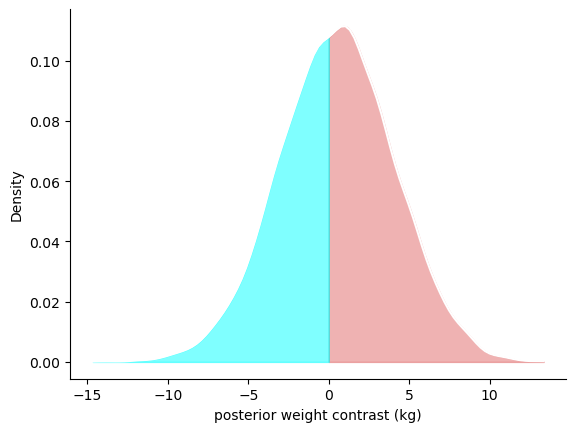

In [26]:
filled_contrast_dist(w_contrast)

/opt/conda/envs/fnds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/fnds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


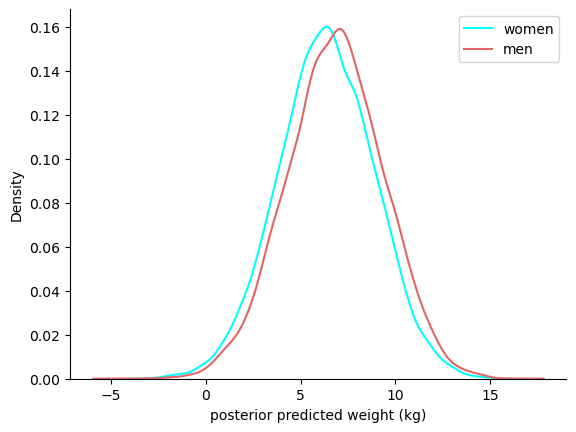

In [27]:
sns.kdeplot(w_W, color = "cyan", label="women")
ax = sns.kdeplot(w_M, color = "#e06666", label="men")
ax.set_xlabel("posterior predicted weight (kg)")
plt.legend()
sns.despine();

In [44]:
avg_heights = d_kid.groupby(["age", "male"])["weight"].mean().reset_index()

# 可选：增加性别标签
avg_heights["gender"] = avg_heights["male"].map({0: "female", 1: "male"})

# 显示结果
avg_heights = avg_heights[["age", "gender", "weight"]]
avg_heights.columns = ["age", "gender", "avg_weight"]

print(avg_heights)

     age  gender  avg_weight
0    0.0  female    6.427237
1    0.0    male    7.328346
2    0.6    male   12.927372
3    1.0  female    7.540967
4    1.0    male    9.252246
5    2.0  female   13.154168
6    2.0    male   10.139671
7    3.0  female   11.701256
8    3.0    male   11.777642
9    4.0  female   12.991158
10   4.0    male   13.139993
11   5.0  female   13.878655
12   5.0    male   14.709341
13   6.0  female   13.943229
14   6.0    male   16.764004
15   6.5  female   10.489315
16   7.0  female   16.650606
17   7.0    male   19.066050
18   7.6    male   11.481547
19   8.0  female   17.240546
20   8.0    male   20.587407
21   8.9    male   17.831836
22   9.0  female   18.275978
23   9.0    male   19.513906
24  10.0  female   20.340766
25  10.0    male   21.205426
26  11.0  female   20.014747
27  11.0    male   21.418047
28  12.0  female   22.815048
29  12.0    male   25.930343


In [13]:
grader.check("q3")

q3 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Before attempting to export your work for submission follow this process: First, make sure you have run all cells in your notebook **in order**. Then, **save your notebook**. Finally, run the export cell below. This sequence of actions will ensure that all code/output/plots appear in the generated PDF. **Only the PDF** will be evaluated for grading purposes.  When executed, the cell below will generate a zip file for you to submit. After making your submission on Gradescope, be sure to **review your submitted PDF** to ensure that it contains all of the work that you want evaluated.

In [14]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

KeyboardInterrupt: 